# Data preparation and cleaning



### Imports for the whole project

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import warnings
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from textblob import TextBlob


e:\Concordia\471-Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Connection to database

In [2]:
dataset_path = 'Customer_support_data.csv'  
data = pd.read_csv(dataset_path)

data.rename(columns={'Customer Remarks': 'Customer_Remarks', 'CSAT Score': 'CSAT_Score'}, inplace=True)

# Print the first few rows of the dataset to confirm it's loaded correctly
print("First few rows of the dataset:")
print(data.head())

# Connect to SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect('customer_support.db')
data.to_sql('customer_support', conn, if_exists='replace', index=False)
cur = conn.cursor()
print("\nSample rows from the 'customer_support' table:")
for row in cur.execute('SELECT * FROM customer_support LIMIT 5'):  # Adjust the LIMIT for more or fewer rows
    print(row)
conn.close()

# Confirm that the database operations are complete
print("\nDatabase operations completed successfully.")

First few rows of the dataset:
                              Unique id channel_name         category  \
0  7e9ae164-6a8b-4521-a2d4-58f7c9fff13f      Outcall  Product Queries   
1  b07ec1b0-f376-43b6-86df-ec03da3b2e16      Outcall  Product Queries   
2  200814dd-27c7-4149-ba2b-bd3af3092880      Inbound    Order Related   
3  eb0d3e53-c1ca-42d3-8486-e42c8d622135      Inbound          Returns   
4  ba903143-1e54-406c-b969-46c52f92e5df      Inbound     Cancellation   

                   Sub-category Customer_Remarks  \
0                Life Insurance              NaN   
1  Product Specific Information              NaN   
2             Installation/demo              NaN   
3        Reverse Pickup Enquiry              NaN   
4                    Not Needed              NaN   

                               Order_id order_date_time Issue_reported at  \
0  c27c9bb4-fa36-4140-9f1f-21009254ffdb             NaN  01/08/2023 11:13   
1  d406b0c7-ce17-4654-b9de-f08d421254bd             NaN  01/08/

### Checking null values within the db

In [3]:
conn = sqlite3.connect('customer_support.db')
customer_support_df = pd.read_sql_query("SELECT * FROM customer_support", conn)
print("DataFrame Information:")
print(customer_support_df.info())
print("\nDescriptive Statistics:")
print(customer_support_df.describe())
print("\nFirst 5 Rows of the DataFrame:")
print(customer_support_df.head())
print("\nCount of Null Values in Each Column:")
print(customer_support_df.isnull().sum())
num_rows_no_nulls = customer_support_df.dropna().shape[0]
print(f"Number of rows with no null values: {num_rows_no_nulls}")
total_rows = customer_support_df.shape[0]
print(f"Total number of rows: {total_rows}")
conn.close()

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85907 entries, 0 to 85906
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unique id                85907 non-null  object 
 1   channel_name             85907 non-null  object 
 2   category                 85907 non-null  object 
 3   Sub-category             85907 non-null  object 
 4   Customer_Remarks         28742 non-null  object 
 5   Order_id                 67675 non-null  object 
 6   order_date_time          17214 non-null  object 
 7   Issue_reported at        85907 non-null  object 
 8   issue_responded          85907 non-null  object 
 9   Survey_response_Date     85907 non-null  object 
 10  Customer_City            17079 non-null  object 
 11  Product_category         17196 non-null  object 
 12  Item_price               17206 non-null  float64
 13  connected_handling_time  242 non-null    float64
 14 

### Processing data in the database

In [4]:
customer_support_df['order_date_time'] = pd.to_datetime(customer_support_df['order_date_time'], dayfirst=True)
customer_support_df['Issue_reported at'] = pd.to_datetime(customer_support_df['Issue_reported at'],dayfirst=True)
customer_support_df['issue_responded'] = pd.to_datetime(customer_support_df['issue_responded'],dayfirst=True)
customer_support_df['Survey_response_Date'] = pd.to_datetime(customer_support_df['Survey_response_Date'],dayfirst=True)
customer_support_df['response_time_minutes'] = (customer_support_df['issue_responded'] - customer_support_df['Issue_reported at']).dt.total_seconds() / 60
customer_support_df['order_hour_of_day'] = customer_support_df['order_date_time'].dt.hour
customer_support_df['issue_reported_hour_of_day'] = customer_support_df['Issue_reported at'].dt.hour
customer_support_df['order_day_of_week'] = customer_support_df['order_date_time'].dt.dayofweek # Extract day of the week (0=Monday, 6=Sunday)
customer_support_df['issue_reported_day_of_week'] = customer_support_df['Issue_reported at'].dt.dayofweek
customer_support_df['elapsed_days_to_survey'] = (customer_support_df['Survey_response_Date'] - customer_support_df['order_date_time']).dt.total_seconds() / (60 * 60 * 24) # Calculate elapsed time from order to survey response (in days)

print("DataFrame Information:")
print(customer_support_df.info())
print("\nDescriptive Statistics:")
print(customer_support_df.describe())
print("\nFirst 5 Rows of the DataFrame:")
print(customer_support_df.head())
print("\nCount of Null Values in Each Column:")
print(customer_support_df.isnull().sum())
num_rows_no_nulls = customer_support_df.dropna().shape[0]
print(f"Number of rows with no null values: {num_rows_no_nulls}")
total_rows = customer_support_df.shape[0]
print(f"Total number of rows: {total_rows}")
conn.close()


C:\Users\matth\AppData\Local\Temp\ipykernel_12296\3803681437.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  customer_support_df['Survey_response_Date'] = pd.to_datetime(customer_support_df['Survey_response_Date'],dayfirst=True)


DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85907 entries, 0 to 85906
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Unique id                   85907 non-null  object        
 1   channel_name                85907 non-null  object        
 2   category                    85907 non-null  object        
 3   Sub-category                85907 non-null  object        
 4   Customer_Remarks            28742 non-null  object        
 5   Order_id                    67675 non-null  object        
 6   order_date_time             17214 non-null  datetime64[ns]
 7   Issue_reported at           85907 non-null  datetime64[ns]
 8   issue_responded             85907 non-null  datetime64[ns]
 9   Survey_response_Date        85907 non-null  datetime64[ns]
 10  Customer_City               17079 non-null  object        
 11  Product_category            171

### Dropping the columns with high null values

In [5]:
customer_support_df.drop(columns=[
    'order_date_time',
    'order_hour_of_day',
    'order_day_of_week',
    'elapsed_days_to_survey',
    'Order_id',
    'Customer_City',
    'Item_price',
    'connected_handling_time',
    'Product_category'
], inplace=True)

# Print the remaining columns and the count of null values in each
print("Remaining columns and the number of null values in each:")
print(customer_support_df.isnull().sum())

num_rows_no_nulls = customer_support_df.dropna().shape[0]
print(f"Number of rows with no null values: {num_rows_no_nulls}")

Remaining columns and the number of null values in each:
Unique id                         0
channel_name                      0
category                          0
Sub-category                      0
Customer_Remarks              57165
Issue_reported at                 0
issue_responded                   0
Survey_response_Date              0
Agent_name                        0
Supervisor                        0
Manager                           0
Tenure Bucket                     0
Agent Shift                       0
CSAT_Score                        0
response_time_minutes             0
issue_reported_hour_of_day        0
issue_reported_day_of_week        0
dtype: int64
Number of rows with no null values: 28742


### Filtering the DF to include only rows with no missing value and creating a new db

In [6]:
complete_cases_df = customer_support_df.dropna()
conn = sqlite3.connect('cleaned_customer_support.db')
complete_cases_df.to_sql('cleaned_customer_support', conn, if_exists='replace', index=False)
conn.close()



In [7]:
conn = sqlite3.connect('cleaned_customer_support.db')
cleaned_df = pd.read_sql_query("SELECT * FROM cleaned_customer_support", conn)
print("Basic statistics of the cleaned database:")
print(cleaned_df.describe())
print("\nInformation about the DataFrame:")
cleaned_df.info()
conn.close()

Basic statistics of the cleaned database:
         CSAT_Score  response_time_minutes  issue_reported_hour_of_day  \
count  28742.000000           28742.000000                28742.000000   
mean       4.073238             130.186835                   14.456718   
std        1.560075             593.501462                    5.066173   
min        1.000000           -1437.000000                    0.000000   
25%        4.000000               2.000000                   11.000000   
50%        5.000000               5.000000                   15.000000   
75%        5.000000              29.000000                   19.000000   
max        5.000000            5742.000000                   23.000000   

       issue_reported_day_of_week  
count                28742.000000  
mean                     2.835050  
std                      1.958646  
min                      0.000000  
25%                      1.000000  
50%                      3.000000  
75%                      5.000000  
max

### Evaluating the sentiment score from the customer remarks column and adding it to the db

In [8]:
conn = sqlite3.connect('cleaned_customer_support.db')
def calculate_sentiment(text):
    try:
        return TextBlob(str(text)).sentiment.polarity
    except:
        return None

cleaned_df['sentiment_score'] = cleaned_df['Customer_Remarks'].apply(calculate_sentiment)
print(cleaned_df[['Customer_Remarks', 'sentiment_score']].head(50))
cleaned_df.to_sql('cleaned_customer_support', conn, if_exists='replace', index=False)

print(cleaned_df.columns)

conn.close()


                                     Customer_Remarks  sentiment_score
0                                           Very good         0.910000
1   Shopzilla app and it's all coustomer care serv...         0.910000
2                                            Very bad        -0.910000
3                                          Something          0.000000
4                                            All good         0.700000
5                                               Good          0.700000
6                                            Godd job         0.000000
7                 Issue not resolved pathetic service        -1.000000
8                                          Excellent          1.000000
9                                          Very good          0.910000
10              Give proper guidance to the customer          0.000000
11  Please highlight if the products cannot be ret...         0.000000
12                                  3000 rupees loss          0.000000
13  Pl

### Trying out some other sentiment score methods

In [10]:
# trying without specific model
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

def calculate_bert_sentiment(text):
    if pd.isna(text):
        return 0  # Assume neutral sentiment for missing remarks
    encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding=True)
    with torch.no_grad():
        outputs = model(**encoded_input)
    scores = torch.nn.functional.softmax(outputs.logits, dim=-1)
    # Assuming that the first class is negative and the second is positive
    positive_score = scores[:,1].item()
    return positive_score


cleaned_df['bert_sentiment'] = cleaned_df['Customer_Remarks'].apply(calculate_bert_sentiment)

# Display the first few entries of the new sentiment scores
print(cleaned_df[['Customer_Remarks', 'bert_sentiment']].head())

# This time, trying a model that's been fine-tuned for sentiment analysis
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)

def calculate_bert_sentiment(text):
    if pd.isna(text):
        return None  # or 0 for neutral sentiment
    result = sentiment_pipeline(text[:512])  
    return result[0]['score'] if result[0]['label'] == 'POSITIVE' else -result[0]['score']

# Apply the function to the Customer_Remarks column
cleaned_df['bert_sentiment2'] = cleaned_df['Customer_Remarks'].apply(calculate_bert_sentiment)

# Show the first few entries of the new sentiment scores
print(cleaned_df[['Customer_Remarks', 'bert_sentiment']].head())
# Drop the 'bert_sentiment' column since it was not a succes for both models
cleaned_df.drop(columns=['bert_sentiment'], inplace=True)
cleaned_df.drop(columns=['bert_sentiment2'], inplace=True)
# Display the DataFrame to confirm the column is dropped
print(cleaned_df.columns)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


                                    Customer_Remarks  bert_sentiment
0                                          Very good        0.518568
1  Shopzilla app and it's all coustomer care serv...        0.627778
2                                           Very bad        0.538639
3                                         Something         0.508091
4                                           All good        0.532200

                                    Customer_Remarks  bert_sentiment
0                                          Very good        0.518568
1  Shopzilla app and it's all coustomer care serv...        0.627778
2                                           Very bad        0.538639
3                                         Something         0.508091
4                                           All good        0.532200
Index(['Unique id', 'channel_name', 'category', 'Sub-category',
       'Customer_Remarks', 'Issue_reported at', 'issue_responded',
       'Survey_response_Date', 'Agent_na

# Linear Regression

### Connect to DB 

In [11]:
conn = sqlite3.connect('cleaned_customer_support.db')
data = pd.read_sql_query("SELECT * FROM cleaned_customer_support", conn)
y = data['CSAT_Score']

### Evaluating some columns from the DB with linear regression

In [12]:
# First going to evaluate the hour when the issue was reported as well as the response time 
X1 = data[['issue_reported_hour_of_day']]
X2 = data[['response_time_minutes']]
# First model based on issue_reported_hour_of_day
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)
model1 = LinearRegression()
model1.fit(X1_train, y_train)
y_pred1 = model1.predict(X1_test)
rmse1 = np.sqrt(mean_squared_error(y_test, y_pred1))
r2_1 = r2_score(y_test, y_pred1)
# Printing relevant data for issue_reported_hour_of_day
print("Model using 'issue_reported_hour_of_day':")
print(f'RMSE: {rmse1:.4f}')
print(f'R-squared: {r2_1:.4f}')
examples = X1_test.copy()  
examples['Actual_CSAT_Score'] = y_test 
examples['Predicted_CSAT_Score'] = y_pred1  
print(examples.head(10))  
# Second model based on response_time_minutes
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)
model2 = LinearRegression()
model2.fit(X2_train, y_train)
y_pred2 = model2.predict(X2_test)
rmse2 = np.sqrt(mean_squared_error(y_test, y_pred2))
r2_2 = r2_score(y_test, y_pred2)
# Printing relevant data for response_time_minutes
print("\nModel using 'response_time_minutes':")
print(f'RMSE: {rmse2:.4f}')
print(f'R-squared: {r2_2:.4f}')
examples = X2_test.copy()  
examples['Actual_CSAT_Score'] = y_test 
examples['Predicted_CSAT_Score'] = y_pred2  
print(examples.head(10))  

Model using 'issue_reported_hour_of_day':
RMSE: 1.5386
R-squared: -0.0010
       issue_reported_hour_of_day  Actual_CSAT_Score  Predicted_CSAT_Score
3394                           13                  4              4.062751
23665                          19                  5              4.071607
8895                           21                  1              4.074559
13218                           9                  4              4.056847
12382                          13                  5              4.062751
2932                            0                  1              4.043563
20001                          18                  5              4.070131
26043                          21                  5              4.074559
3023                            7                  5              4.053895
5102                           13                  5              4.062751

Model using 'response_time_minutes':
RMSE: 1.5218
R-squared: 0.0207
       response_time_minutes  Ac

### Third model based on Agent Shift which needs one hot encoder to preprocess the data since the shifts are split into known ones

In [13]:
encoder = OneHotEncoder() 
X3_encoded = encoder.fit_transform(data[['Agent Shift']])
shift_categories = encoder.categories_[0] 
X3_train, X3_test, y_train, y_test = train_test_split(X3_encoded, y, test_size=0.2, random_state=42)
model3 = LinearRegression()
model3.fit(X3_train, y_train)
y_pred3 = model3.predict(X3_test)
mse3 = mean_squared_error(y_test, y_pred3)
r2_3 = r2_score(y_test, y_pred3)
mapped_categories = {int(i): category[0] for i, category in enumerate(shift_categories)}
X3_test_df = pd.DataFrame.sparse.from_spmatrix(X3_test)
X3_test_df = X3_test_df.rename(columns=mapped_categories)
X3_test_df = X3_test_df.astype(int)

X3_test_df.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
examples = X3_test_df.copy()  
examples['Actual_CSAT_Score'] = y_test 
examples['Predicted_CSAT_Score'] = y_pred3 
rmse3 = np.sqrt(mean_squared_error(y_test, y_pred3))
r2_2 = r2_score(y_test, y_pred3)
print("\nModel using 'Agent Shift':")
print(shift_categories)
print(f'RMSE: {rmse3:.4f}')
print(f'R-squared: {r2_2:.4f}')
print(examples.head(10))


Model using 'Agent Shift':
['Afternoon' 'Evening' 'Morning' 'Night' 'Split']
RMSE: 1.5361
R-squared: 0.0023
   A  E  M  N  S  Actual_CSAT_Score  Predicted_CSAT_Score
0  0  0  1  0  0                  4              4.001691
1  0  0  1  0  0                  5              4.001691
2  1  0  0  0  0                  1              4.137886
3  0  0  1  0  0                  4              4.001691
4  0  1  0  0  0                  5              4.096031
5  0  1  0  0  0                  1              4.096031
6  0  1  0  0  0                  5              4.096031
7  0  1  0  0  0                  5              4.096031
8  0  0  0  0  1                  5              4.338692
9  0  0  1  0  0                  5              4.001691


### Running through all the columns to find the best one for linear regression

issue_reported_hour_of_day, RMSE: 1.5600,R2 Score: 1.3802251463967963e-07


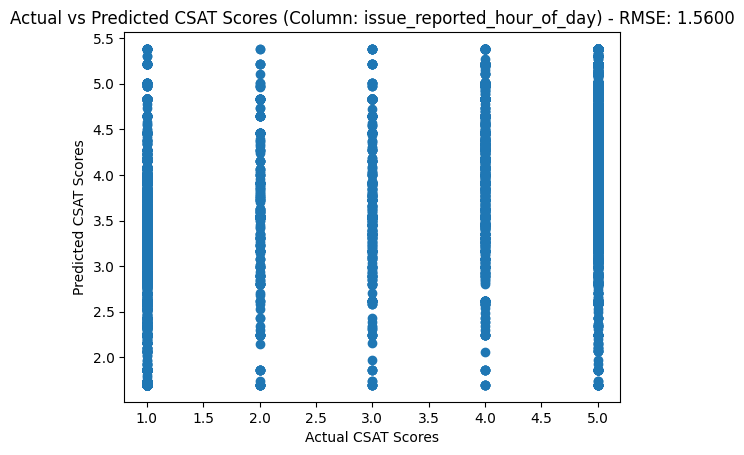

issue_reported_day_of_week, RMSE: 1.5600,R2 Score: 2.3443426213631824e-05


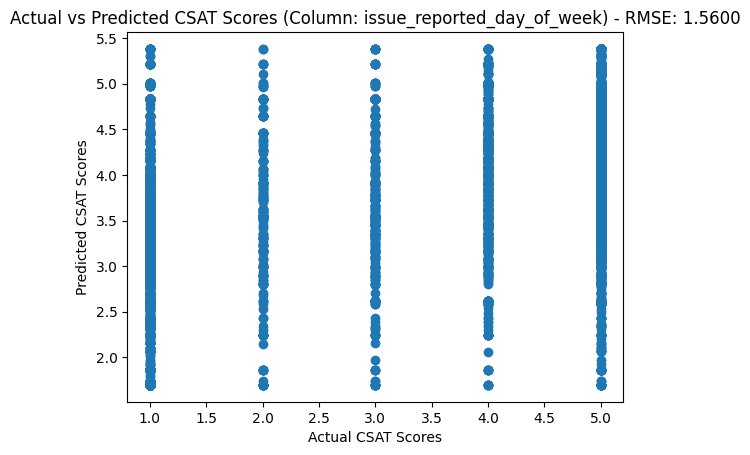

Agent Shift, RMSE: 1.5580,R2 Score: 0.002673726320066905


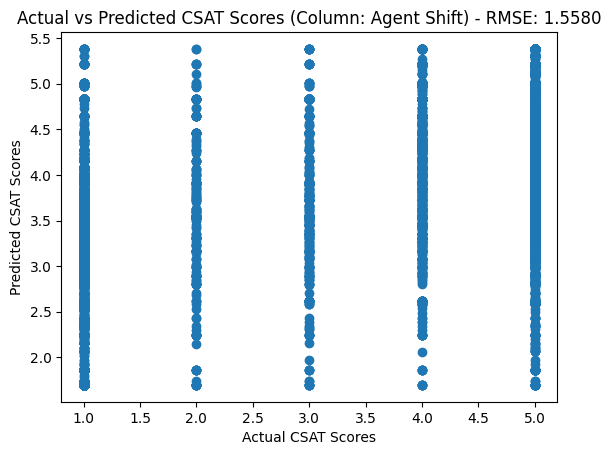

channel_name, RMSE: 1.5578,R2 Score: 0.002943236250615766


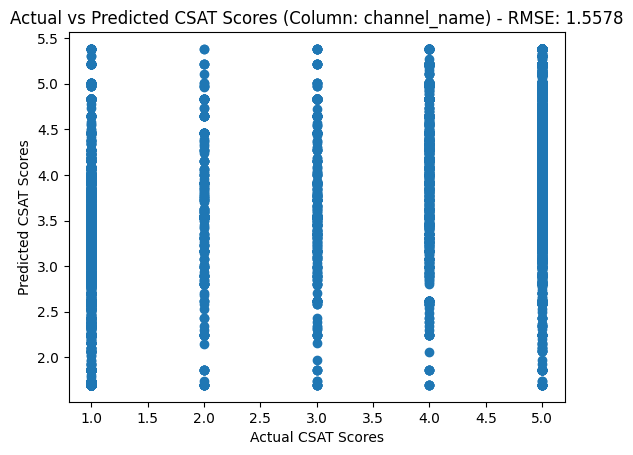

Tenure Bucket, RMSE: 1.5570,R2 Score: 0.0038440370863059847


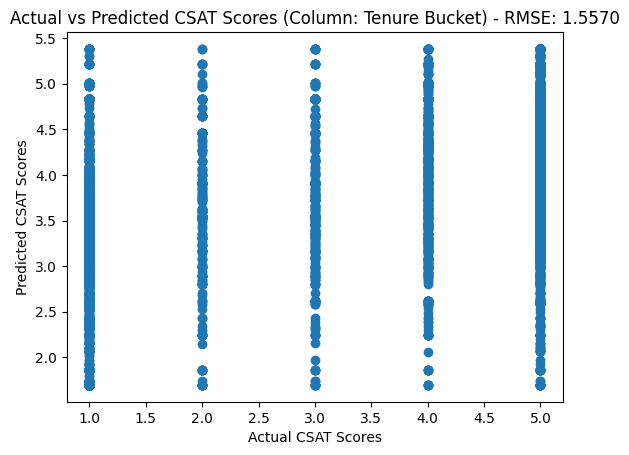

Manager, RMSE: 1.5552,R2 Score: 0.006255897168794489


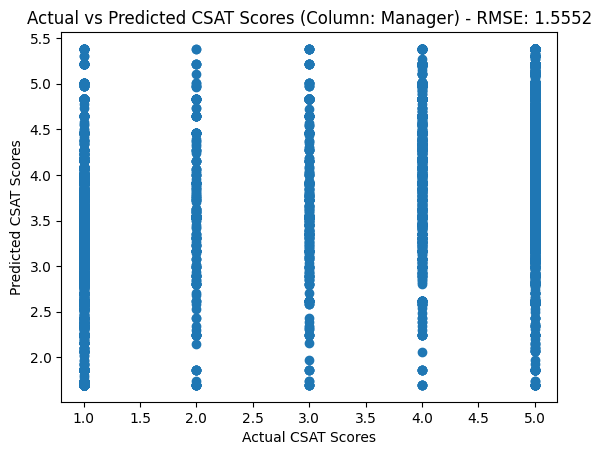

Supervisor, RMSE: 1.5506,R2 Score: 0.012075728216115467


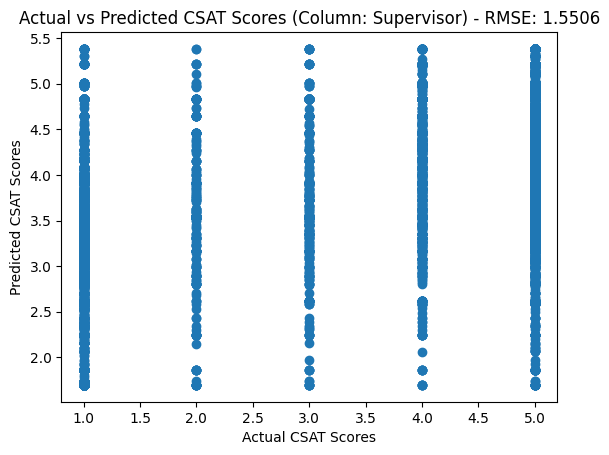

category, RMSE: 1.5495,R2 Score: 0.013416106853163856


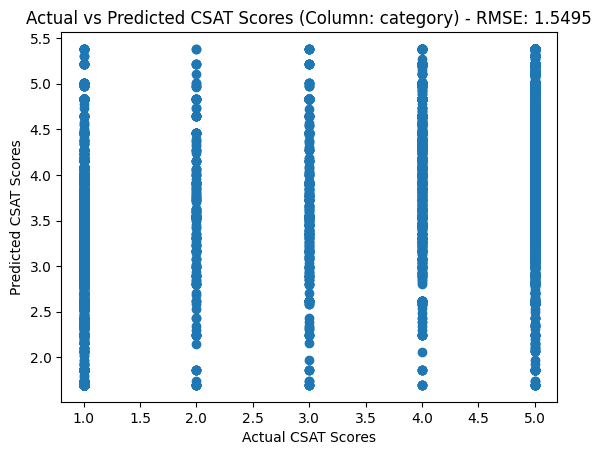

response_time_minutes, RMSE: 1.5383,R2 Score: 0.027669547640037484


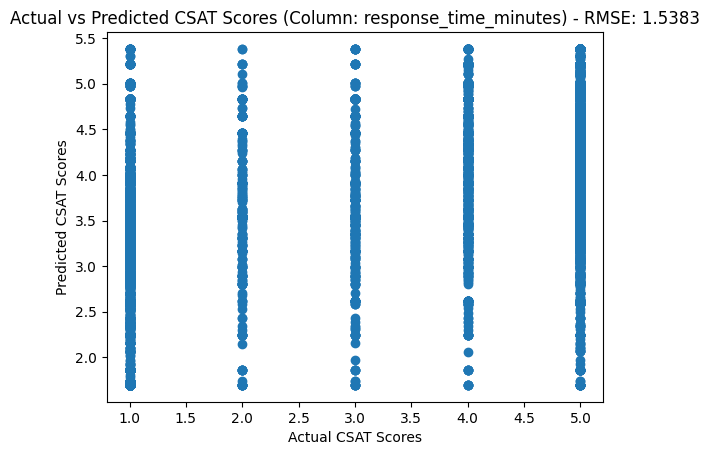

Sub-category, RMSE: 1.5193,R2 Score: 0.051564993303777396


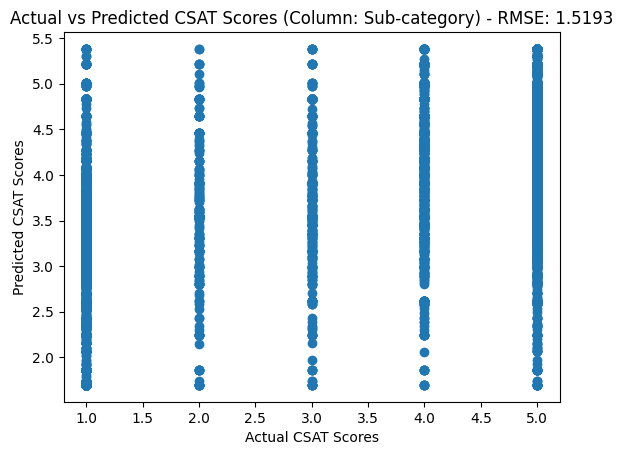

Agent_name, RMSE: 1.4712,R2 Score: 0.1106129667317034


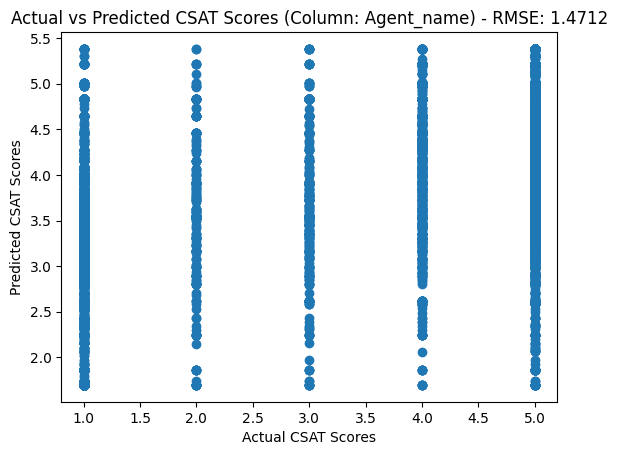

sentiment_score, RMSE: 1.3302,R2 Score: 0.2729336876970063


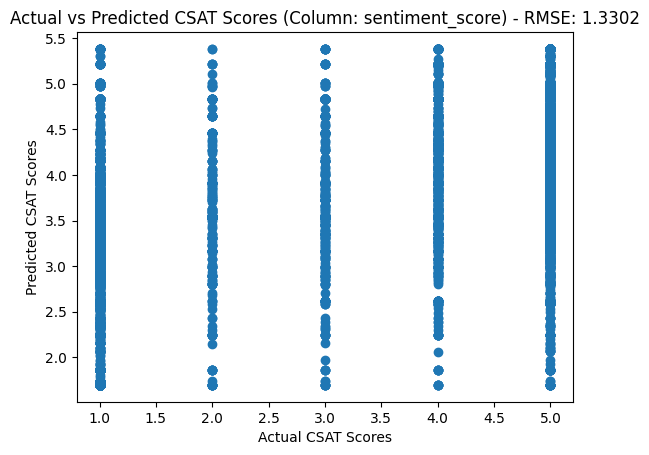

CSAT_Score, RMSE: 0.0000,R2 Score: 1.0


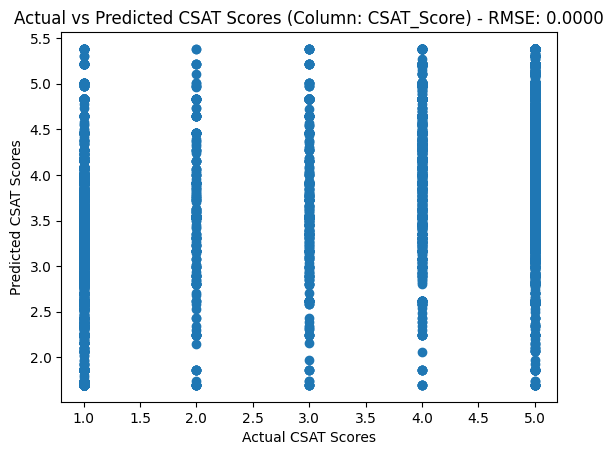

In [14]:
def plot(column,r2,rmse):
    print(f'{column}, RMSE: {rmse:.4f},R2 Score: {r2}')
    # Plot actual vs predicted CSAT scores
    plt.scatter(data['CSAT_Score'], y_pred, alpha=1)
    plt.xlabel('Actual CSAT Scores')
    plt.ylabel('Predicted CSAT Scores')
    plt.title(f'Actual vs Predicted CSAT Scores (Column: {column}) - RMSE: {rmse:.4f}')
    plt.show()
    return rmse

rmse_dict = {}
for column in data.columns:
    X = None
    if column in ['Unique id','Customer_Remarks','Issue_reported at','issue_responded','Survey_response_Date']:
        continue
    elif column in ['channel_name', 'category', 'Sub-category','Tenure Bucket','Agent Shift']:
          # Create categories using OneHotEncoder
        encoder = OneHotEncoder(drop='first')
        X_encoded = encoder.fit_transform(data[[column]])
        X = pd.DataFrame.sparse.from_spmatrix(X_encoded)
    elif column in ['Agent_name', 'Supervisor', 'Manager']:
        # Here we apply get dummies to put numerical values for this feature where there are a lot of different people
        X = pd.get_dummies(data[column], prefix=column)
    else:
        X = data[[column]]

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    rmse_dict[column] = (rmse,r2)

sorted_rmse = sorted(rmse_dict.items(), key=lambda x: x[1], reverse=True)

# Printing the worst models first
for column, (rmse,r2) in sorted_rmse:
    plot(column,r2,rmse)

### Testing some random combinations of columns and printing the best RMSEs

In [15]:
warnings.filterwarnings("ignore")   # Just removing the warning for sparse arrays
def preprocess_data(data):
    processed_data = pd.DataFrame()  
    for column in data.columns:
        if column in ['Unique id','Customer_Remarks','Issue_reported at','issue_responded','Survey_response_Date','CSAT_Score']:
            continue
        elif column in ['channel_name', 'category', 'Sub-category','Tenure Bucket','Agent Shift']:
            encoder = OneHotEncoder(drop='first')
            X_encoded = encoder.fit_transform(data[[column]])
            X = pd.DataFrame.sparse.from_spmatrix(X_encoded)
        elif column in ['Agent_name', 'Supervisor', 'Manager']:
            X = pd.get_dummies(data[column], prefix=column)
        else:
            X = data[[column]]
        processed_data = pd.concat([processed_data, X], axis=1) 
    processed_data.columns = processed_data.columns.astype(str)  
    return processed_data

def evaluate_model(X_train, X_test, y_train, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse



def random_feature_combinations(features, num_combinations, max_columns=5):
    combinations = []
    agents = set([feature.split('_')[0] for feature in features])
    other_columns = ['Agent_name', 'Supervisor', 'Manager']  
    for _ in range(num_combinations):
        combination = []
        shuffled_features = list(features)
        np.random.shuffle(shuffled_features)
        for agent in agents:
            agent_features = [feature for feature in shuffled_features if feature.startswith(agent)]
            if agent_features:
                selected_feature = np.random.choice(agent_features)
                combination.append(selected_feature)
                if len(combination) >= max_columns:
                    break 
        for column in other_columns:
            if column in features:
                combination.append(column) 
        combinations.append(tuple(combination))
    return combinations


processed_data = preprocess_data(data)
X_train, X_test, y_train, y_test = train_test_split(processed_data, y, test_size=0.2, random_state=42)
print(data.columns)
features = processed_data.columns
print(features)
num_combinations = 10000    # 100000 Did it for 100 000k to get some good combinations but we reach a peak at rmse of 1.5
max_columns = 10
combinations = random_feature_combinations(features, num_combinations, max_columns)
results = {}
for i, combination in enumerate(combinations):
    print(f"Evaluating combination {i+1}/{num_combinations}: {combination}")
    X_train_comb = X_train[list(combination)]
    X_test_comb = X_test[list(combination)]
    rmse = evaluate_model(X_train_comb, X_test_comb, y_train, y_test)
    results[combination] = rmse

sorted_results = sorted(results.items(), key=lambda x: x[1])
print("\nTop 5 Best Combinations:")
for i, (combination, rmse) in enumerate(sorted_results[:5], 1): 
    print(f"{i}. Combination: {combination}, RMSE: {rmse:.4f}")


Index(['Unique id', 'channel_name', 'category', 'Sub-category',
       'Customer_Remarks', 'Issue_reported at', 'issue_responded',
       'Survey_response_Date', 'Agent_name', 'Supervisor', 'Manager',
       'Tenure Bucket', 'Agent Shift', 'CSAT_Score', 'response_time_minutes',
       'issue_reported_hour_of_day', 'issue_reported_day_of_week',
       'sentiment_score'],
      dtype='object')
Index(['0', '1', '0', '1', '2', '3', '4', '5', '6', '7',
       ...
       '2', '3', '0', '1', '2', '3', 'response_time_minutes',
       'issue_reported_hour_of_day', 'issue_reported_day_of_week',
       'sentiment_score'],
      dtype='object', length=1497)
Evaluating combination 1/10000: ('11', '0', '53', '44', '6', '52', '54', '8', '30', 'Supervisor_Nathan Patel')
Evaluating combination 2/10000: ('11', '0', '53', '44', '6', '52', '54', '8', '30', 'Supervisor_Ava Wong')
Evaluating combination 3/10000: ('11', '0', '53', '4', '6', '52', '54', '8', '30', 'Supervisor_Alexander Tanaka')
Evaluating com